# Overview 

There are many different data sources on the web regarding cybersec ml. However, lot of the code is not Open Source (Surprise!).

Here there is a list of different distros and articles found:

- Jivoi Github data and papers [collection](https://github.com/jivoi/awesome-ml-for-cybersecurity)
- Shramos data and papers [collection](https://github.com/shramos/Awesome-Cybersecurity-Datasets)
- westxdev data and papers [collection](https://github.com/shramos/Awesome-Cybersecurity-Datasets) 
  - Attention to [this](http://www.secrepo.com/) data collection, it is interesting.
- Az Secure datasets, [here](https://www.azsecure-data.org/other-data.html)
- Daniel Bohannon [revoke obfuscation](https://github.com/danielbohannon/Revoke-Obfuscation)
- Daniel Bohannon [powershell corpus](https://onedrive.live.com/?authkey=%21AC9cbXs-twuSZ-E&cid=7874CFD565B38D4B&id=7874CFD565B38D4B%211091892&parId=7874CFD565B38D4B%211091891&action=defaultclick)
- Using deep learning to detect malicious powershell commands [paper](https://arxiv.org/pdf/1804.04177.pdf)
- Attack detection [paper](https://arxiv.org/pdf/1806.08110.pdf)
- **Survey on deep learning techniques in cybersec** [paper](https://www.mdpi.com/2078-2489/10/4/122/pdf)
- Unsupervised deep learning for threat detection [here](file:///home/jams/Scaricati/15126-68350-2-PB.pdf)
- Machine Learning and malicious code [FireEye](https://www.fireeye.com/blog/threat-research/2018/07/malicious-powershell-detection-via-machine-learning.html)
- University of new Brunswick - [Datasetst](https://www.unb.ca/cic/datasets/)
- exPose a framework on detecting malicious filepaths, urls and registry key [paper](https://arxiv.org/pdf/1702.08568.pdf) 
- Convnet and intrusion detection [paper](file:///home/jams/Scaricati/icacci-presentation-CNNintrusion.pdf)
- An article treating Infosec and Data Science [overview](https://www.analyticsvidhya.com/blog/2018/02/demystifying-security-data-science/) 
- A survey on IDS datasets [paper](https://arxiv.org/pdf/1903.02460.pdf)
-**Particularly interesting dataset** [here](https://www.unb.ca/cic/datasets/ids-2018.html)

![alt_text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/01/Evoluation-of-DS-768x457.png)


# KDD cup

Approaches followed:

- [first](https://pdfs.semanticscholar.org/8101/1998c41e00d6b2a4dbb84dbeb2d8f51bb895.pdf)
- Second - Home made -> a riedition of a Resnet1d (winning one)

# Results get:

99.02% Accuracy from first two epochs

## Data Retrieval:

In [ ]:
!mkdir ./new_data
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz 

--2020-07-13 08:20:26--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  39.9MB/s    in 0.4s    

2020-07-13 08:20:26 (39.9 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]



In [ ]:
!ls .

kddcup.data.gz	new_data  sample_data


In [ ]:
import os
import pandas as pd
import psutil
import humanize
import numpy as np
import tensorflow as tf
import keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import re
from keras.utils import to_categorical
from keras.layers import Flatten,BatchNormalization,LSTM, Dense, Dropout,Conv1D,\
MaxPooling1D,Input,Reshape, Add, Activation, ZeroPadding1D, AveragePooling1D, Embedding
from keras.models import Sequential, Model
from keras.initializers import glorot_uniform
from keras.layers.embeddings import Embedding
from keras.callbacks import History
from keras.optimizers import Adam,SGD,Adadelta,RMSprop
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD as tsvd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from keras.utils import to_categorical, plot_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Columns extraction:

In [ ]:
names="""duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous."""

In [ ]:
columns = [el[0] for el in [names.split('\n')[l].split(':') for l in range(len(names.split('\n')))]]
columns.append('labels')

## Data Reading:

In [ ]:
data = pd.read_csv('kddcup.data.gz',header=None,names=columns,compression='gzip')
print(data.shape)

(4898431, 42)


In [ ]:
data = data.drop_duplicates()
print(data.shape)

(1074992, 42)


In [ ]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
data.select_dtypes('object').apply(lambda x:x.nunique())

protocol_type     3
service          70
flag             11
labels           23
dtype: int64

In [ ]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1074992.0,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06
mean,1.348908e+02,5.837540e+03,4.873730e+03,2.418623e-05,2.735834e-03,3.627934e-05,5.427947e-02,1.460476e-04,6.301163e-01,3.570817e-02,3.023278e-04,1.674431e-04,5.875300e-02,5.416784e-03,3.386072e-04,4.320032e-03,0.0,1.860479e-06,3.802819e-03,4.934544e+01,1.297961e+01,1.901168e-01,1.908070e-01,7.811688e-02,7.793043e-02,7.785663e-01,3.159951e-02,1.179070e-01,1.619723e+02,1.592091e+02,6.700944e-01,4.949892e-02,9.335762e-02,2.173602e-02,1.906580e-01,1.901296e-01,7.954099e-02,7.829662e-02
std,1.321605e+03,2.009617e+06,1.376866e+06,4.917892e-03,8.835986e-02,1.540162e-02,9.974618e-01,1.558112e-02,4.827732e-01,8.232096e+00,1.738496e-02,1.725250e-02,8.406153e+00,2.650495e-01,1.864927e-02,7.347828e-02,0.0,1.363993e-03,6.154966e-02,8.523218e+01,2.941398e+01,3.909777e-01,3.916605e-01,2.669225e-01,2.659105e-01,3.917200e-01,1.169086e-01,2.655164e-01,1.022645e+02,1.098842e+02,4.259518e-01,1.310801e-01,2.298291e-01,5.636309e-02,3.907621e-01,3.913478e-01,2.621995e-01,2.609840e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01,1.800000e+01,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.190000e+02,3.320000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,8.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.240000e+02,2.480000e+02,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.060000e+02,1.721000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,3.400000e+01,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02,9.000000e-02,2.550000e+02,2.550000e+02,1.000000e+00,6.000000e-02,4.000000e-02,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [ ]:
data.shape
y=data.labels
data.drop('labels',axis=1,inplace=True)

## Data Preprocessing

In [ ]:
data_exec = pd.concat([pd.get_dummies(data.select_dtypes('object'),drop_first=True),data.select_dtypes(exclude='object')],axis=1)

In [ ]:
del data

In [ ]:
columns = data_exec.columns

In [ ]:
data_exec.shape

(1074992, 119)

In [ ]:
y.value_counts()

normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: labels, dtype: int64

### Data Scaling and Normalization:

In [ ]:
mms = MinMaxScaler()

In [ ]:
mms.partial_fit(data_exec.iloc[:np.int(data_exec.shape[0]/2),:])
mms.partial_fit(data_exec.iloc[np.int(data_exec.shape[0]/2)+1:,:])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
data_exec1=pd.DataFrame(mms.transform(data_exec.iloc[:np.int(data_exec.shape[0]/2),:]),columns=columns)
data_exec2=pd.DataFrame(mms.transform(data_exec.iloc[np.int(data_exec.shape[0]/2):,:]),columns=columns)

In [ ]:
del data_exec

In [ ]:
print(data_exec1.shape)
print(data_exec2.shape)

(537496, 119)
(537496, 119)


In [ ]:
dd = pd.concat([data_exec1,data_exec2],axis=0)

In [ ]:
del data_exec2,data_exec1

## Tools creation

In [ ]:
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.2 GB  | Proc size: 5.4 GB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
tgt=pd.get_dummies(y)

In [ ]:
tgt.head()

,back.,buffer_overflow.,ftp_write.,guess_passwd.,imap.,ipsweep.,land.,loadmodule.,multihop.,neptune.,nmap.,normal.,perl.,phf.,pod.,portsweep.,rootkit.,satan.,smurf.,spy.,teardrop.,warezclient.,warezmaster.
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(dd,tgt,stratify=tgt,shuffle=True,train_size=0.95)

In [ ]:
del dd

In [ ]:
x_test.shape

(53750, 119)

NB: possible improvement with SMOTE.

In [ ]:
x_train=x_train.values.reshape(x_train.shape[0],x_train.shape[1],1)

In [ ]:
x_test=x_test.values.reshape(x_test.shape[0],x_test.shape[1],1)

## First Model

From resnet blocks

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Resnet 50 paper
    Arguments:
    X -- input tensor of shape (m, n_W_prev, 1)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X


def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Resnet 50 Paper
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv1D(F1, 1, strides=s, name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization( name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv1D(F3, 1, strides=s, name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def resnet_1d(input_shape,classes=10):
  
    """
    Returns:
    model -- a Model() instance in Keras. The architecture is mutuated from 
    resnet concept.
    """
    X_input = Input(input_shape)
        
    X = ZeroPadding1D(2)(X_input)
   # Stage 1
#   X = Conv1D(filters = 50,kernel_size = 3,strides=2,padding = 'valid',name = 'conv_layer_short_1',activity_regularizer=l2(l=0.02))(X)
#   X = BatchNormalization(name='bn_conv1')(X)
#   X = Activation('relu')(X)
#   X = MaxPooling1D(3, strides=2)(X)
## Following, there are different sections not used in the actual code stage.
    X = Conv1D(filters = 20,kernel_size = 10,strides=2,padding = 'valid',name = 'conv_layer_short_2')(X)
    X = BatchNormalization(name='bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=2)(X)
   # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=2)
    X = identity_block(X,1, [64, 64, 256], stage=2, block='b')
    X = identity_block(X,1, [64, 64, 256], stage=2, block='c')
 
  # Ultima modifica, nei blocchi qui sotto ed in stage 2, i 5 ed i 3 erano 1
 
   # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 1, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 1, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 1, [128, 128, 512], stage=3, block='d')
  
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 1, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 1, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 1, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 1, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 1, [256, 256, 1024], stage=4, block='f')
  
    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 1, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 1, [512, 512, 2048], stage=5, block='c')
 
    X = AveragePooling1D(1,name = 'AVG_POOL1')(X)
   
  
    # output layer
#    X = LSTM(50,return_sequences=True)(X)
#    X = LSTM(classes)(X)
    X = Flatten()(X)
    X = Dense(700, activation = 'relu',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.8)(X)
    X = Dense(200, activation = 'relu',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dropout(0.6)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
#    X = Conv1D(filters = 25,kernel_size = 1,strides=1,padding = 'valid',name = 'conv_layer_final1',activity_regularizer=l2(l=0.002))(X)
#    X = Activation('relu')(X)
#    X = Conv1D(filters = classes,kernel_size = 1,padding = 'same',name = 'conv_layer_final2',activity_regularizer=l2(l=0.002))(X)
#    X = Activation('softmax')(X)
#   Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
  
    return model 

## Second Model

Here we present an alternative model

In [ ]:
def model_creation(attack,dropout_rate=[0.4,0.2,0.4]):
  model = Sequential()
  model.add(Dense(1500,activation='relu',kernel_initializer='glorot_normal',input_shape=(attack.shape[1],))) # Try with more neurons per unit and with more dropouts. Now rate=0.2 and 0.1 tomorrow rate = 0.4 and 0.5 and more layers. Prolly conv layer necessary.
  model.add(BatchNormalization())
  model.add(Dropout(rate = 0.4))
  model.add(Dense(2000,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(rate = 0.6))
  #model.add(Dense(800,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(Dense(700,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(Dropout(rate=dropout_rate[0]))
  model.add(BatchNormalization())
  #model.add(Dense(800,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(Dropout(rate=dropout_rate[1]))
  model.add(Dense(1500,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization())
  model.add(Dropout(rate = 0.4))  
  model.add(Dense(500,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(BatchNormalization()) #da valutare se tenerlo o meno.
  model.add(Dropout(rate = 0.4))
  model.add(Dense(350, activation = 'relu',kernel_initializer = 'glorot_normal'))
  model.add(Dropout(rate=dropout_rate[2]))
  model.add(Dense(100,activation = 'relu',kernel_initializer='glorot_normal'))
  model.add(Dropout(rate = 0.4))
  model.add(Dense(35,activation = 'relu',kernel_initializer = 'glorot_normal'))
  model.add(Dense(10,activation='softmax'))
  history=History()
  return model


def model2(input_shape,conv=True,n_classes = 10):
  
  X_input = Input(input_shape,name = 'input_layer')
  
  if conv == True:
    
 #   X_input = Reshape(input_shape = input_shape ,target_shape=(input_shape,),name = 'reshape_layer')(X_input)
    
    X_short = Conv1D(filters = 175,kernel_size = 10,strides=4,padding = 'same',name = 'conv_layer_short',kernel_initializer = 'glorot_normal')(X_input)
    X_short = BatchNormalization(momentum=0.995,scale=True,axis = 1, name = 'Batch_Norm_short')(X_short)
    X_short = Activation('relu')(X_short)
    
#    X_short_1 = Conv1D(filters = 50,kernel_size = 3,strides=1,padding = 'same',name = 'conv_layer_short_1',kernel_initializer = 'glorot_normal')(X_input)
#    X_short_1 = BatchNormalization(momentum=0.995,scale=True,axis = 1, name = 'Batch_Norm_short_1')(X_short_1)
#    X_short_1 = Activation('relu')(X_short_1)
#    X_short_1 = Conv1D(filters = 150,kernel_size = 3,strides=1,padding = 'same',name = 'conv_layer_short_2',kernel_initializer = 'glorot_normal')(X_input)
#    X_short_1 = BatchNormalization(momentum=0.995,scale=True,axis = 1, name = 'Batch_Norm_short_2')(X_short_1)
#    X_short_1 = Activation('relu')(X_short_1)
#    X_short_1 = Conv1D(filters = 300,kernel_size = 3,strides=2,padding = 'same',name = 'conv_layer_short_3',kernel_initializer = 'glorot_normal')(X_input)
#    X_short_1 = BatchNormalization(momentum=0.995,scale=True,axis = 1, name = 'Batch_Norm_short_3')(X_short_1)
#    X_short_1 = Activation('relu')(X_short_1)
#    X_short_1 = MaxPooling1D(pool_size=2)(X_short_1)
    
    X = Conv1D(filters = 25, kernel_size = 5,strides=2,padding = 'same',name = 'fourth_layer',kernel_initializer = 'glorot_normal')(X_input)
    X = BatchNormalization(axis = 1, name = 'Batch_Norm5')(X)    
    X = Activation('relu')(X)
    X = Conv1D(filters = 50, kernel_size = 5,strides=2,padding = 'same',name = 'third_layer',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm4')(X)
    X = Activation('relu')(X)    
    X = Conv1D(filters = 75, kernel_size = 5,strides=2,padding = 'same',name = 'second_layer',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm32')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=1)(X)
    X = Conv1D(filters = 100, kernel_size = 5,strides=2,padding = 'same',name = 'sess_layer',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm3')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=1)(X)
    X = Conv1D(filters = 125, kernel_size = 5,strides=2,padding = 'same',name = 'secossnd_layer_1',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm211')(X)
    X = Activation('relu')(X)
    X = Conv1D(filters = 150, kernel_size = 5,strides=2,padding = 'same',name = 'first_qlayer',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm21')(X)  
    X = Activation('relu')(X)
#    X = MaxPooling1D(pool_size=2)(X)
    X = Conv1D(filters = 175, kernel_size = 5,strides=1,padding = 'same',name = 'first_layer',kernel_initializer = 'glorot_normal')(X)
    X = BatchNormalization(axis = 1,name ='Batc1h_Norm1')(X)  
#    X = Activation('relu')(X)
#    X = Conv1D(filters = 200, kernel_size = 5,strides=1,padding = 'same',name = 'second_layer_2',kernel_initializer = 'glorot_normal')(X)
    
    X = Activation('relu')(X)
#    X = MaxPooling1D(pool_size=2)(X)    
    
#    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=2)(X)    

    X = Add(name='Add_Layer')([X,X_short])
    X = BatchNormalization(axis = 1,name ='Batc1h_Norm14545')(X)
    X = Activation('relu')(X)
#    X = LSTM(100, return_sequences=True)(X)
    
#    X = Conv1D(filters = 250, kernel_size = 3,strides=1,padding = 'same',name = 'final_layer1',kernel_initializer = 'glorot_normal')(X)
#    X = BatchNormalization(axis = 1,name ='Batch_Norm7')(X)  
#    X = Activation('relu')(X)
#    X = Conv1D(filters = 300, kernel_size = 3,strides=1,padding = 'same',name = 'final_layer2',kernel_initializer = 'glorot_normal')(X)
#    X = BatchNormalization(axis = 1,name ='Batch_Norm8')(X)
#    X = Activation('relu')(X)
#    X = Add(name='Add_layer2')([X,X_short_1])
#    X = MaxPooling1D(pool_size = 3, padding = 'same',name = 'pool_2')(X)
    X = Flatten()(X)
    X = Dense(800,activation = 'relu',name='FC1',kernel_initializer = 'glorot_normal')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(200,activation = 'relu',name='FC2',kernel_initializer = 'glorot_normal')(X)
    X = Dropout(rate=0.3)(X)
    X = Dense(n_classes,activation = 'softmax',name='output_layer',kernel_initializer = 'glorot_normal')(X)
    model = Model(inputs=X_input, outputs = X,name = 'Convnet')
  
  else:
    
#    X = Dense(1000,activation='relu',kernel_initializer='glorot_normal')(X_input) # Try with more neurons per unit and with more dropouts. Now rate=0.2 and 0.1 tomorrow rate = 0.4 and 0.5 and more layers. Prolly conv layer necessary.
#    X = BatchNormalization()(X)
#    X = Dropout(rate = 0.4)(X)
#    X = Embedding(1000,128)(X_input)
#    X = BatchNormalization()(X)
#    X = Dropout(rate = 0.2)(X)
#    X = Dense(1500,activation = 'relu',kernel_initializer='glorot_normal')(X)
#    X = BatchNormalization()(X)
#    X = Dropout(rate = 0.4)(X)
#    X = Reshape(input_shape=(1500,),target_shape=(1500,1))(X)
#!    X = Conv1D(filters = 64, kernel_size = 3,strides=2,padding = 'valid',kernel_initializer='glorot_normal',name = 'second_layer_1a')(X)
#!    X = BatchNormalization(axis = 1,name ='Batch_Norm1')(X)  
#!    X = Activation('relu')(X)
#!    X = Conv1D(filters = 64, kernel_size = 3,strides=1,padding = 'valid',kernel_initializer='glorot_normal',name = 'second_layer_1b')(X)
#!    X = BatchNormalization(axis = 1,name ='Batch_Norm2')(X)  
#!    X = Activation('relu')(X)
#    X = MaxPooling1D(pool_size=20,padding='same')(X)
    X = Conv1D(filters = 25, kernel_size = 7,strides=1,padding = 'same',kernel_initializer='glorot_normal',name = 'second_layer_2a')(X_input)
    X = BatchNormalization(axis = 1,name ='Batch_Norm3')(X)  
    X = Activation('relu')(X)
    X = Conv1D(filters = 50, kernel_size = 7,strides=1,padding = 'valid',kernel_initializer='glorot_normal',name = 'second_layer_2b')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm4')(X)  
    X = Activation('relu')(X)
 #   X = MaxPooling1D(pool_size=2,padding='same')(X)
    X = Conv1D(filters = 100, kernel_size = 9,strides=1,padding = 'valid',kernel_initializer='glorot_normal',name = 'second_layer_3')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm5')(X)  
    X = Activation('relu')(X)
    X = Conv1D(filters = 200, kernel_size = 9,strides=1,padding = 'same',kernel_initializer='glorot_normal',name = 'second_layer_4')(X)
    X = BatchNormalization(axis = 1,name ='Batch_Norm51')(X)  
    X = Activation('relu')(X)
    X = MaxPooling1D(pool_size=5,padding='same')(X)
    X = Flatten()(X)
#    X = LSTM(200,return_sequences=True)(X)
#    X = LSTM(100)(X)
#    X = Dense(300,activation = 'relu',kernel_initializer='glorot_normal')(X)
#    X = BatchNormalization()(X)
#    X = Dropout(rate=0.4)(X)
#!    X = Dense(750,activation = 'relu',kernel_initializer='glorot_normal')(X)
#!    X = BatchNormalization()(X)
#!    X = Dropout(rate=0.5)(X)
#!    X = Dense(300,activation = 'relu',kernel_initializer='glorot_normal')(X)
#!    X = BatchNormalization()(X) #da valutare se tenerlo o meno.
#    X = Dense(750, activation = 'relu',kernel_initializer = 'glorot_normal')(X)
#    X = Dropout(rate = 0.2)(X)
#!    X = Reshape(input_shape=(300,),target_shape=(300,1))(X)  
#!    X = LSTM(n_classes,activation='softmax')(X)
    X = Dense(150,activation = 'relu',kernel_initializer='glorot_normal')(X)
#    X = Dropout(rate = 0.4)(X)
    X = Dense(50,activation = 'relu',kernel_initializer = 'glorot_normal')(X)#    X = Dropout(rate = 0.4)(X)
    X = Dense(n_classes,activation='softmax')(X)
    model = Model(inputs=X_input, outputs = X,name = 'FullyConnected')
  return model  

 #Last: Without majority class

## And now, Training

What else should I say?

In [ ]:
y_train.shape

(1021242, 23)

In [ ]:
mod=resnet_1d(x_train.shape[1:3],classes=23)

In [ ]:
mod.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 119, 1)       0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 123, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_layer_short_2 (Conv1D)     (None, 57, 20)       220         zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
bn_conv2 (BatchNormalization)   (None, 57, 20)       80          conv_layer_short_2[0][0]         
___________________________________________________________________________________________

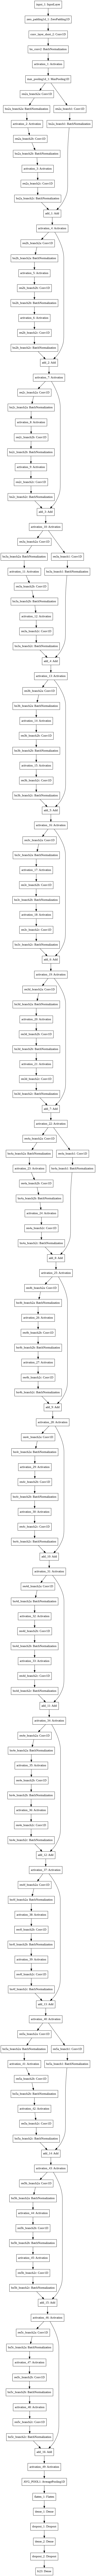

In [ ]:
plot_model(mod)

In [ ]:
mod.compile(optimizer=Adam(lr=0.003,decay=1e-4,beta_1=0.995,beta_2=0.9995),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=History()

In [ ]:
x_train.shape

(1021242, 119, 1)

In [ ]:
x_test.shape

(53750, 119, 1)

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9226671304170566309
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5455225157861946338
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14071207647411344021
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 251642497540165680
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
data = mod.fit(x_train,y_train,validation_split=0.05,epochs=20,callbacks=[history],batch_size=2**11) 

Train on 970179 samples, validate on 51063 samples
Epoch 1/20
970179/970179 [==============================] - 200s 206us/step - loss: 0.2214 - accuracy: 0.9638 - val_loss: 0.4287 - val_accuracy: 0.9769
Epoch 2/20
970179/970179 [==============================] - 178s 184us/step - loss: 0.0532 - accuracy: 0.9835 - val_loss: 0.0500 - val_accuracy: 0.9929
Epoch 3/20
970179/970179 [==============================] - 178s 183us/step - loss: 0.0423 - accuracy: 0.9882 - val_loss: 0.1521 - val_accuracy: 0.9895
Epoch 4/20
970179/970179 [==============================] - 178s 183us/step - loss: 0.0319 - accuracy: 0.9911 - val_loss: 0.1178 - val_accuracy: 0.9945
Epoch 5/20
970179/970179 [==============================] - 178s 183us/step - loss: 0.0256 - accuracy: 0.9932 - val_loss: 0.0182 - val_accuracy: 0.9953
Epoch 6/20
970179/970179 [==============================] - 178s 183us/step - loss: 0.0227 - accuracy: 0.9942 - val_loss: 0.0374 - val_accuracy: 0.9956
Epoch 7/20
970179/970179 [===========

In [ ]:
df_hist = pd.DataFrame(data.history)

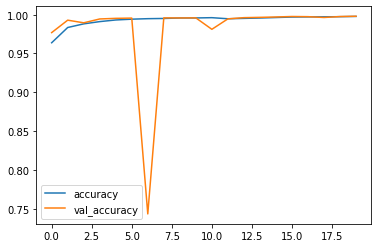

In [ ]:
df_hist[['accuracy','val_accuracy']].plot()

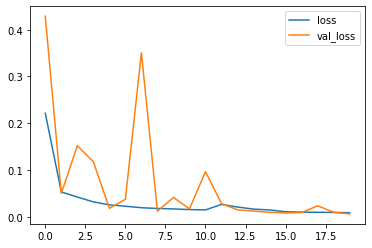

In [ ]:
df_hist[['loss','val_loss']].plot()

In [ ]:
mod.evaluate(x_test,y_test,batch_size=128)

53750/53750 [==============================] - 7s 138us/step


[0.006573434610612864, 0.9981395602226257]

In [ ]:
prediction = mod.predict(x_test)

In [ ]:
y_test.shape

(53750, 23)

In [ ]:
predictions = (prediction > 0.6).astype('int')

In [ ]:
y_test.values.argmax(axis=1)

array([11,  9, 11, ..., 11, 11, 11])

In [ ]:
predictions.shape

(53750, 23)

In [ ]:
prediction = to_categorical(prediction)

In [ ]:
precision_score(y_test,predictions,average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.998719068319084

In [ ]:
recall_score(y_test,predictions,average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9976186046511628

In [ ]:
f1_score(y_test,predictions,average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


0.9981391533627774